# Unlockable V2 notebook

## Initial

In [25]:
import ast
import pandas as pd
import numpy as np
import utils
import os
import getpass
from datetime import date
import datetime 
import json
import time
import sys
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('fivethirtyeight')
%load_ext autoreload
%autoreload 2

username = getpass.getuser()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 60%; }
    div#maintoolbar-container { width: 70%; }
    div.output_scroll { height: 60em; }
</style>
"""))

In [3]:
data_path = 'data'

if not os.path.exists(data_path):
    os.makedirs(data_path)

## HELPER FUNCTIONS

In [4]:
def query_short(q):
    conn = pyodbc.connect('DSN=Redshift_live')
    df = pd.read_sql(q, conn)
    conn.close()
    return df

windows_connection_name = 'DSN=Redshift_live'

import platform
import json
import datetime

def query(q):
#     if platform.system() == 'Windows':
#         conn = pyodbc.connect(windows_connection_name)
#     elif platform.system() == 'Darwin':
#         with open(mac_redshift_user_file) as fh:
#             creds = json.loads(fh.read())  
#         conn = ('postgresql+psycopg2://' + \
#             creds['user_name'] + ':' + creds['password'] + '@' + \
#             creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'])
#     else: ##Returns the system/OS name, such as 'Linux', 'Darwin', 'Java', 'Windows'. An empty string is returned if the value cannot be determined.
#         return null
            
    print("query started at: {0}".format(datetime.datetime.now().time()))
    df = pd.read_sql(q, conn, chunksize = None)
    print("query ended at: {0}".format(datetime.datetime.now().time()))    
    conn.close()
    return df


import scipy.stats as st
alpha = 0.95 #significance_level

def ttest_2(a,b):
    return st.ttest_ind(a,b, equal_var=False)

def ci(a, alpha):
    t = st.t.interval(alpha, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    return (t[1] - t[0])/2

def list_to_string(lst):
    s = ",".join(map(str, lst))   
    return s

def string_list_to_string(lst):
    s = "'"+"','".join(map(str, lst))+"'"   
    return s


## SQL string

In [5]:
sql = """

with s as (
	select 
    '{0}'::date as dt_start, --campaign start day
	'{1}'::date as dt_end, --campaign end day
	'{2}' as city,
    '{3}'::date as activity_end
)
,
cities as (
	select 
		id,
		country_code
	from admin_system_city c 
	where name = (select city from s)
)
,
users as (
SELECT 
	t.id as test_id,
	t.name as test_name,
	e.user_id,
	e.created AS enrollment_created,
	case when tr.bonus_type = 'targeted_control_campaign' THEN 'control' ELSE 'treatment' END AS treatment_type,
	case when tr.bonus_type = 'targeted_control_campaign' THEN 1 ELSE 0 END AS is_control,
	json_extract_path_text(tr.bonus_data,'targeted_campaign_id') targeted_campaign_id_str,
	case when targeted_campaign_id_str ='' then null else targeted_campaign_id_str::int end as targeted_campaign_id,
    c.name as campaign_name,
	json_extract_path_text(c.bonus_data,'percentage') campaign_percentage,
	json_extract_path_text(c.bonus_data,'max_value') campaign_max_value,
	case when hu.user_id is null then 0 else 1 end as is_in_holdout,
	h."created" as holdout_start,
	h."end" as holdout_end
FROM public.campaign_targeting_test t 
left join public.campaign_targeting_treatment tr on tr.test_id = t.id
LEFT JOIN public.campaign_targeting_enrollment e on e.treatment_id = tr.id
left join campaign_targeted_campaign c on c.id = case when json_extract_path_text(tr.bonus_data,'targeted_campaign_id') ='' then null else json_extract_path_text(tr.bonus_data,'targeted_campaign_id')::int end
LEFT JOIN campaign_consumer_holdouts_holdout h on tr.external_holdout_reference = h.id
LEFT join campaign_consumer_holdouts_holdout_user hu on hu.user_id = e.user_id  and hu.holdout_id = h.id
where 
	date_trunc('week',t.created)::date = (select date_trunc('week',dt_start)::date from s)
	AND e.state = 'finished' --enrollments without error
	AND e.no = 1 --get only the first enrollment
	
    and t.name ilike '%unlockable%'
    --and t.city_id = (select id from cities)
)
,
hp_end as (select max(holdout_end) hp_end from users)
,
orders as (
	SELECT DISTINCT
		company_order_search_filter__filter_search_category_id AS category,
		company_order__id AS order_id,
		company_order_try__driver_id AS driver_id,
		company_order__user_id AS user_id,
		company_order__country country,
		
		company_order__state AS o_state,
		company_order__created o_created,
		
		company_order_try__id as ot_id,
		company_order_try__state AS ot_state,
		company_order_try__created ot_created,
		--DATE_TRUNC('hour', company_order_try__created) AS date_hour,
			
		COALESCE(company_order_try__ride_price/cr.rate,0) ride_price,
		COALESCE(company_order_try__price/cr.rate,0) price,
		ride_price - (case when tcc.order_try_id is null then ride_price else price end) as discount, --discount from signup campaigns under analysis
		ride_price - price as discount_all, --all discounts, including GGs, other campaigns, compensations etc
		
		company_order_try__retry_to_try,
		
		case 
			when v.company_order_try__created::date <= (select dt_end from s) then 'dp' 
			when u.is_in_holdout = 1 and v.company_order_try__created <= u.holdout_end then 'hp'
			else 'other'
		end as period_type
	
	FROM etl_search_denormalized_view v
	INNER JOIN users u ON u.user_id = v.company_order__user_id --select only users in the sample
	LEFT JOIN vw_currency_exchange_rates cr ON 
	            (company_order_try__price_currency = cr.currency) 
	            AND DATE(cr.valid_on) = DATE(company_order_try__created)
	LEFT JOIN (select * from campaign_targeted_campaign_code_usage tcc where tcc.targeted_campaign_id IN (select distinct t.targeted_campaign_id from users t where t.targeted_campaign_id is not null)
				) tcc on 
	    			tcc.order_try_id = v.company_order_try__id 
	    			AND tcc.user_id = v.company_order__user_id
	WHERE 
		v.company_order_try__created::date >= (SELECT dt_start FROM s) --global monitoring period 
		AND v.company_order_try__created::date <= (SELECT activity_end FROM s) --greatest((SELECT dt_end FROM s),(select hp_end from hp_end)) --global monitoring period, max from camapign or holdout end
		AND v.company_order__city_id in (SELECT id FROM cities)
		AND v.company_order__country in (SELECT country_code FROM cities)
		AND company_order_try__state = 'finished'
		AND v.company_order__state = 'finished'
		AND company_order_try__retry_to_try is null
		AND not nvl(duplicate_order, false) 
)
,
orders_agg AS (
	SELECT 
		o.user_id, 
		o.period_type,
		min(o.ot_created) as first_order_created, 
		count(o.order_id) as finished_order_count,
		sum(o.ride_price) ride_price,
		sum(o.price) price,
		sum(o.discount) discount,
		sum(o.discount_all) discount_all
	FROM orders o 
	where o.period_type = 'dp'
	group by o.user_id, o.period_type
)
,
orders_agg_hp AS (
	SELECT 
		o.user_id, 
		o.period_type,
		min(o.ot_created) as first_order_created, 
		count(o.order_id) as finished_order_count,
		sum(o.ride_price) ride_price,
		sum(o.price) price,
		sum(o.discount) discount,
		sum(o.discount_all) discount_all
	FROM orders o 
	where o.period_type = 'hp'
	group by o.user_id, o.period_type
)
,
users_activity AS (
	SELECT 
	
		--user details
		u.user_id,
		u.test_id,
		u.test_name,
        u.campaign_name,
		u.treatment_type,
		u.is_control,
		u.targeted_campaign_id,
		u.campaign_percentage,
		u.campaign_max_value,	
		u.is_in_holdout,
	
		--order aggregations from discount period
		coalesce(od.finished_order_count,0) finished_order_count,
		coalesce(od.ride_price,0) ride_price_sum,
		coalesce(od.price,0) price_sum,
		coalesce(od.discount,0) discount_sum,
		coalesce(od.discount_all,0) discount_all_sum,
		case when coalesce(od.finished_order_count,0)>0 then 1 else 0 end as has_ride,
		
		--order aggregations from holdout period
		case when u.is_in_holdout then coalesce(oh.finished_order_count,0) else null end as hp_finished_order_count,
		case when u.is_in_holdout then coalesce(oh.ride_price,0) else null end as hp_ride_price_sum,
		case when u.is_in_holdout then coalesce(oh.price,0) else null end as hp_price_sum,
		case when u.is_in_holdout then coalesce(oh.discount,0) else null end as hp_discount_sum,
		case when u.is_in_holdout then coalesce(oh.discount_all,0) else null end as hp_discount_all_sum,
		case when u.is_in_holdout then case when coalesce(oh.finished_order_count,0)>0 then 1 else 0 end else null end as hp_has_ride

	FROM users u
	left join orders_agg od on od.user_id = u.user_id
	left join orders_agg_hp oh on oh.user_id = u.user_id 
    
)
select 
    *
from users_activity 
order by user_id

"""

In [6]:
sql_mod = """

with s as (
	select 
    '{0}'::date as dt_start, --campaign start day
	'{1}'::date as dt_end, --campaign end day
	'{2}' as city,
    '{3}'::date as activity_start,
    '{4}'::date as activity_end
)
,
cities as (
	select 
		id,
		country_code
	from admin_system_city c 
	where name = (select city from s)
)
,
users as (
SELECT 
	t.id as test_id,
	t.name as test_name,
	e.user_id,
	e.created AS enrollment_created,
	case when tr.bonus_type = 'targeted_control_campaign' THEN 'control' ELSE 'treatment' END AS treatment_type,
	case when tr.bonus_type = 'targeted_control_campaign' THEN 1 ELSE 0 END AS is_control,
	json_extract_path_text(tr.bonus_data,'targeted_campaign_id') targeted_campaign_id_str,
	case when targeted_campaign_id_str ='' then null else targeted_campaign_id_str::int end as targeted_campaign_id,
    c.name as campaign_name,
	json_extract_path_text(c.bonus_data,'percentage') campaign_percentage,
	json_extract_path_text(c.bonus_data,'max_value') campaign_max_value,
	case when hu.user_id is null then 0 else 1 end as is_in_holdout,
	h."created" as holdout_start,
	h."end" as holdout_end
FROM public.campaign_targeting_test t 
left join public.campaign_targeting_treatment tr on tr.test_id = t.id
LEFT JOIN public.campaign_targeting_enrollment e on e.treatment_id = tr.id
left join campaign_targeted_campaign c on c.id = case when json_extract_path_text(tr.bonus_data,'targeted_campaign_id') ='' then null else json_extract_path_text(tr.bonus_data,'targeted_campaign_id')::int end
LEFT JOIN campaign_consumer_holdouts_holdout h on tr.external_holdout_reference = h.id
LEFT join campaign_consumer_holdouts_holdout_user hu on hu.user_id = e.user_id  and hu.holdout_id = h.id
where 
	date_trunc('week',t.created)::date = (select date_trunc('week',dt_start)::date from s)
	AND e.state = 'finished' --enrollments without error
	AND e.no = 1 --get only the first enrollment
	
    and t.name ilike '%unlockable%'
    --and t.city_id = (select id from cities)
)
,
hp_end as (select max(holdout_end) hp_end from users)
,
orders as (
	SELECT DISTINCT
		company_order_search_filter__filter_search_category_id AS category,
		company_order__id AS order_id,
		company_order_try__driver_id AS driver_id,
		company_order__user_id AS user_id,
		company_order__country country,
		
		company_order__state AS o_state,
		company_order__created o_created,
		
		company_order_try__id as ot_id,
		company_order_try__state AS ot_state,
		company_order_try__created ot_created,
		--DATE_TRUNC('hour', company_order_try__created) AS date_hour,
			
		COALESCE(company_order_try__ride_price/cr.rate,0) ride_price,
		COALESCE(company_order_try__price/cr.rate,0) price,
		ride_price - (case when tcc.order_try_id is null then ride_price else price end) as discount, --discount from signup campaigns under analysis
		ride_price - price as discount_all, --all discounts, including GGs, other campaigns, compensations etc
		
		company_order_try__retry_to_try,
		
		case 
			when v.company_order_try__created::date <= (select activity_end from s) then 'dp' 
			when u.is_in_holdout = 1 and v.company_order_try__created <= u.holdout_end then 'hp'
			else 'other'
		end as period_type
	
	FROM etl_search_denormalized_view v
	INNER JOIN users u ON u.user_id = v.company_order__user_id --select only users in the sample
	LEFT JOIN vw_currency_exchange_rates cr ON 
	            (company_order_try__price_currency = cr.currency)
	            AND DATE(cr.valid_on) = DATE(company_order_try__created)
	LEFT JOIN (select * from campaign_targeted_campaign_code_usage tcc where tcc.targeted_campaign_id IN (select distinct t.targeted_campaign_id from users t where t.targeted_campaign_id is not null)
				) tcc on 
	    			tcc.order_try_id = v.company_order_try__id 
	    			AND tcc.user_id = v.company_order__user_id
	WHERE 
		v.company_order_try__created::date >= (SELECT activity_start FROM s) --global monitoring period 
		AND v.company_order_try__created::date <= (SELECT activity_end FROM s)--greatest((SELECT dt_end FROM s),(select hp_end from hp_end)) --global monitoring period, max from camapign or holdout end
		AND v.company_order__city_id in (SELECT id FROM cities)
		AND v.company_order__country in (SELECT country_code FROM cities)
		AND company_order_try__state = 'finished'
		AND v.company_order__state = 'finished'
		AND company_order_try__retry_to_try is null
		AND not nvl(duplicate_order, false) 
)
,
orders_agg AS (
	SELECT 
		o.user_id, 
		o.period_type,
		min(o.ot_created) as first_order_created, 
		count(o.order_id) as finished_order_count,
		sum(o.ride_price) ride_price,
		sum(o.price) price,
		sum(o.discount) discount,
		sum(o.discount_all) discount_all
	FROM orders o 
	where o.period_type = 'dp'
	group by o.user_id, o.period_type
)
,
orders_agg_hp AS (
	SELECT 
		o.user_id, 
		o.period_type,
		min(o.ot_created) as first_order_created, 
		count(o.order_id) as finished_order_count,
		sum(o.ride_price) ride_price,
		sum(o.price) price,
		sum(o.discount) discount,
		sum(o.discount_all) discount_all
	FROM orders o 
	where o.period_type = 'hp'
	group by o.user_id, o.period_type
)
,
users_activity AS (
	SELECT 
	
		--user details
		u.user_id,
		u.test_id,
		u.test_name,
        u.campaign_name,
		u.treatment_type,
		u.is_control,
		u.targeted_campaign_id,
		u.campaign_percentage,
		u.campaign_max_value,	
		u.is_in_holdout,
	
		--order aggregations from discount period
		coalesce(od.finished_order_count,0) finished_order_count,
		coalesce(od.ride_price,0) ride_price_sum,
		coalesce(od.price,0) price_sum,
		coalesce(od.discount,0) discount_sum,
		coalesce(od.discount_all,0) discount_all_sum,
		case when coalesce(od.finished_order_count,0)>0 then 1 else 0 end as has_ride,
		
		--order aggregations from holdout period
		case when u.is_in_holdout then coalesce(oh.finished_order_count,0) else null end as hp_finished_order_count,
		case when u.is_in_holdout then coalesce(oh.ride_price,0) else null end as hp_ride_price_sum,
		case when u.is_in_holdout then coalesce(oh.price,0) else null end as hp_price_sum,
		case when u.is_in_holdout then coalesce(oh.discount,0) else null end as hp_discount_sum,
		case when u.is_in_holdout then coalesce(oh.discount_all,0) else null end as hp_discount_all_sum,
		case when u.is_in_holdout then case when coalesce(oh.finished_order_count,0)>0 then 1 else 0 end else null end as hp_has_ride

	FROM users u
	left join orders_agg od on od.user_id = u.user_id
	left join orders_agg_hp oh on oh.user_id = u.user_id 
    
)
select 
    *
from users_activity 
order by user_id

"""

## Get Cohorts

In [8]:
conf_template = {'city': '',
 'country': '',
 #'rfm_calculation_date': '2020-06-14',
 #'alive_week_date': '2020-06-15',
 'de_discount_start_date': ''
 #'de_discount_end_date': '2020-06-23',
 #'de_holdout_start_date': '2020-06-23',
 #'de_holdout_end_date': '2020-06-30',
 #'test_name': 'simulation_za_Durban_2020-06-16_2020-06-22',
 #'experiment_group_column': 'discount',
 #'slice_cols': ['cohort'],
 #'city_test_ids': [7099, 7097, 7096, 7095, 7094, 7093],
 #'city_control_treatment_ids': [13562, 13567, 13574, 13581, 13588, 13595],
 #'city_treatment_share': 2,
 #'city_n_treatments': 4,
 #'additional_sql_enrollment_selection': '',
 #'use_holdout_targeting': 0
}

In [9]:
cities = ["Durban"]
countries = ["za"]
weeks = ["2021-01-27"]

In [10]:
i = 0

for city in cities:

    country = countries[i]
    i=i+1
    
    for w in weeks:
        if True:
            conf = conf_template
            conf["city"] = city
            conf["country"] = country
            conf["de_discount_start_date"] = w

            print('{} {} {}'.format(city, w ,datetime.datetime.now().time()))

            ##get cohorts
            dfc = utils.get_cohorts_etl(conf, data_path, overwrite_file = False)

    #         ##get session cohorts
    #         dfcs = utils.get_cohorts_sessions(conf, data_path, overwrite_file = True)

    #         ## get lifetime activity
    #         dfla = utils.get_lifetime_activity(conf, data_path)

    #         ## get RFMv1 cohorts
    #         dfc1 = utils.get_cohorts_rfmv1(conf, data_path, overwrite_file = True)

#             ## get alive probability
#             dfap = utils.get_alive_probability(conf, data_path, overwrite_file = False)

    #         ##get cherrypickers
    #         dfch = utils.get_cherrypickers(conf, data_path)

    #         ##get profitability
    #         dfp = utils.get_profit(conf, data_path)

    #         ##get activity
    #         dfa = utils.get_activity(conf, data_path)


Durban 2021-01-27 09:59:17.911105
Reading cohort ETL data from csv...


In [11]:
dfc.head()

,method,period,city,country,cohort,user_id
0,rfmv2,2021-01-27,Durban,za,not_active_last_4_month,669417
1,rfmv2,2021-01-27,Durban,za,high_recency,947686
2,rfmv2,2021-01-27,Durban,za,high_frequency,959709
3,rfmv2,2021-01-27,Durban,za,highest_activity,1041736
4,rfmv2,2021-01-27,Durban,za,high_recency,1057590


In [12]:
dfc.groupby('cohort').user_id.count()

cohort
high_frequency                      93446
high_recency                        95351
highest_activity                    79569
low_activity                        84130
med_activity                        43532
not_active_last_4_month            655046
signed_up_less_than_14_days_ago     19472
Name: user_id, dtype: int64

# Analysis

# All period (2 weeks of campaigns + 2 week of holdout)

In [13]:
w = "2021-01-25" #input the week of the first campaign
activity_start = '2021-01-28'
activity_end = '2021-02-24'

In [14]:
w = "2021-01-25" #input the week of the first campaign
overwrite_file = True

if country in ['za','ee','lv','lt']:
    #campaigns starting on Thu
    campaign_start = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=3)).strftime('%Y-%m-%d')
    campaign_end = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=3+6)).strftime( '%Y-%m-%d')
else:
    #campaigns starting on Tue
    campaign_start = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    campaign_end = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=1+6)).strftime( '%Y-%m-%d')  

filename_df_riders = 'test_activity_{}_{}_{}_{}.csv'.format(country, city,campaign_start,campaign_end)

if filename_df_riders not in os.listdir(data_path) or overwrite_file: 
    dfa = utils.read_from_redshift(sql_mod.format(
        campaign_start,
        campaign_end,
        city,
        activity_start,
        activity_end
    )) 
    dfa.to_csv('{}/{}'.format(data_path,filename_df_riders), compression='gzip', index=False)
else:
    print('reading from file')
    dfa = pd.read_csv('{}/{}'.format(data_path,filename_df_riders), compression = 'gzip')

    

query started at: 09:59:45.513869
query ended at: 10:01:09.064111


In [15]:
dfa.groupby('is_in_holdout').user_id.count()

is_in_holdout
0    150737
1     81592
Name: user_id, dtype: int64

In [16]:
dfa.groupby('campaign_name').user_id.count()

campaign_name
ZA, Durban, 2021W4, unlockable lock test, -10% x 10 (5 ZAR)     11592
ZA, Durban, 2021W4, unlockable lock test, -20% x 10 (10 ZAR)    11788
ZA, Durban, 2021W4, unlockable lock test, -30% x 10 (15 ZAR)    11675
ZA, Durban, 2021W4, unlockable rfm test, -10% x 10 (5 ZAR)      11538
ZA, Durban, 2021W4, unlockable rfm test, -20% x 10 (10 ZAR)     11638
ZA, Durban, 2021W4, unlockable rfm test, -30% x 10 (15 ZAR)     11712
Name: user_id, dtype: int64

In [146]:
dft.groupby(['treatment2', 'cohort']).user_id.count().to_csv('quick.csv')

In [104]:
#order campaigns in advance
order_list = ['None_control', 
              'ZA, Durban, 2021W4, unlockable lock test, -10% x 10 (5 ZAR)_10', 
              'ZA, Durban, 2021W4, unlockable rfm test, -10% x 10 (5 ZAR)_10', 
              'ZA, Durban, 2021W4, unlockable lock test, -20% x 10 (10 ZAR)_20', 
              'ZA, Durban, 2021W4, unlockable rfm test, -20% x 10 (10 ZAR)_20', 
              'ZA, Durban, 2021W4, unlockable lock test, -30% x 10 (15 ZAR)_30', 
              'ZA, Durban, 2021W4, unlockable rfm test, -30% x 10 (15 ZAR)_30']

### Merge cohorts and rename treatment

In [17]:
dft = dfa.merge(dfc, how = 'left', on = 'user_id')

dft["campaign_percentage"] = dft["campaign_percentage"].astype(str)
dft["treatment"] = np.where((dft["is_control"]==1),'control',dft["campaign_percentage"])

dft["treatment"] = np.where((dft["treatment"]=='nan'),'no_treatment',dft["treatment"])

In [18]:
#add campaign name to treatment! 
dft['treatment2'] = dft['campaign_name'].astype(str) + '_' + dft['treatment'].astype(str)
dft['treatment2'].unique()

array(['None_control',
       'ZA, Durban, 2021W4, unlockable rfm test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable lock test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable lock test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable rfm test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable rfm test, -20% x 10 (10 ZAR)_20',
       'ZA, Durban, 2021W4, unlockable lock test, -20% x 10 (10 ZAR)_20'],
      dtype=object)

In [19]:
dft = dft[dft.is_in_holdout == 1]

In [147]:
dft

,user_id,test_id,test_name,campaign_name,treatment_type,is_control,targeted_campaign_id,campaign_percentage,campaign_max_value,is_in_holdout,finished_order_count,ride_price_sum,price_sum,discount_sum,discount_all_sum,has_ride,hp_finished_order_count,hp_ride_price_sum,hp_price_sum,hp_discount_sum,hp_discount_all_sum,hp_has_ride,method,period,city,country,cohort,treatment,treatment2
5,584162,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable rfm test, -10% ...",treatment,0,22907.000,10,5,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,10,"ZA, Durban, 2021W4, unlockable rfm test, -10% ..."
6,589037,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
9,597949,16047,"ZA, Durban, 2021W4, unlockable lock test, HF","ZA, Durban, 2021W4, unlockable rfm test, -10% ...",treatment,0,22907.000,10,5,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_frequency,10,"ZA, Durban, 2021W4, unlockable rfm test, -10% ..."
13,624623,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
14,628941,16047,"ZA, Durban, 2021W4, unlockable lock test, HF",None,control,1,nan,None,None,1,1,10.276,10.276,0.000,0.000,1,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_frequency,control,None_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232318,62559349,16046,"ZA, Durban, 2021W4, unlockable lock test, HR",None,control,1,nan,None,None,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,control,None_control
232321,62559683,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -20%...",treatment,0,22905.000,20,10,1,1,1.471,1.199,0.272,0.272,1,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,20,"ZA, Durban, 2021W4, unlockable lock test, -20%..."
232325,62561205,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
232326,62561256,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable rfm test, -30% ...",treatment,0,22909.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable rfm test, -30% ..."


,user_id,test_id,test_name,campaign_name,treatment_type,is_control,targeted_campaign_id,campaign_percentage,campaign_max_value,is_in_holdout,finished_order_count,ride_price_sum,price_sum,discount_sum,discount_all_sum,has_ride,hp_finished_order_count,hp_ride_price_sum,hp_price_sum,hp_discount_sum,hp_discount_all_sum,hp_has_ride,method,period,city,country,cohort,treatment,treatment2
5,584162,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable rfm test, -10% ...",treatment,0,22907.000,10,5,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,10,"ZA, Durban, 2021W4, unlockable rfm test, -10% ..."
6,589037,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
9,597949,16047,"ZA, Durban, 2021W4, unlockable lock test, HF","ZA, Durban, 2021W4, unlockable rfm test, -10% ...",treatment,0,22907.000,10,5,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_frequency,10,"ZA, Durban, 2021W4, unlockable rfm test, -10% ..."
13,624623,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
14,628941,16047,"ZA, Durban, 2021W4, unlockable lock test, HF",None,control,1,nan,None,None,1,1,10.276,10.276,0.000,0.000,1,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_frequency,control,None_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232318,62559349,16046,"ZA, Durban, 2021W4, unlockable lock test, HR",None,control,1,nan,None,None,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,control,None_control
232321,62559683,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -20%...",treatment,0,22905.000,20,10,1,1,1.471,1.199,0.272,0.272,1,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,20,"ZA, Durban, 2021W4, unlockable lock test, -20%..."
232325,62561205,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
232326,62561256,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable rfm test, -30% ...",treatment,0,22909.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable rfm test, -30% ..."


In [20]:
dft.groupby(['treatment2', 'has_ride']).mean()

user_id  \
treatment2                                         has_ride                
None_control                                       0        40957796.815   
                                                   1        37804683.779   
ZA, Durban, 2021W4, unlockable lock test, -10% ... 0        41101766.093   
                                                   1        37647009.067   
ZA, Durban, 2021W4, unlockable lock test, -20% ... 0        41352215.997   
                                                   1        37951203.975   
ZA, Durban, 2021W4, unlockable lock test, -30% ... 0        41111934.729   
                                                   1        37729818.572   
ZA, Durban, 2021W4, unlockable rfm test, -10% x... 0        41145233.563   
                                                   1        37804555.584   
ZA, Durban, 2021W4, unlockable rfm test, -20% x... 0        40964279.568   
                                                   1        38239258.152   
ZA, Durban, 2021W4, unlockable rfm test, -30% x... 0        41392472.134   
                                                   1        37632748.079   

                                                              test_id  \
treatment2                                         has_ride             
None_control                                       0        16046.215   
                                                   1        16046.227   
ZA, Durban, 2021W4, unlockable lock test, -10% ... 0        16046.222   
                                                   1        16046.201   
ZA, Durban, 2021W4, unlockable lock test, -20% ... 0        16046.222   
                                                   1        16046.216   
ZA, Durban, 2021W4, unlockable lock test, -30% ... 0        16046.234   
                                                   1        16046.202   
ZA, Durban, 2021W4, unlockable rfm test, -10% x... 0        16046.210   
                                                   1        16046.190   
ZA, Durban, 2021W4, unlockable rfm test, -20% x... 0        16046.216   
                                                   1        16046.211   
ZA, Durban, 2021W4, unlockable rfm test, -30% x... 0        16046.199   
                                                   1        16046.215   

                                                             is_control  \
treatment2                                         has_ride               
None_control                                       0              1.000   
                                                   1              1.000   
ZA, Durban, 2021W4, unlockable lock test, -10% ... 0              0.000   
                                                   1              0.000   
ZA, Durban, 2021W4, unlockable lock test, -20% ... 0              0.000   
                                                   1              0.000   
ZA, Durban, 2021W4, unlockable lock test, -30% ... 0              0.000   
                                                   1              0.000   
ZA, Durban, 2021W4, unlockable rfm test, -10% x... 0              0.000   
                                                   1              0.000   
ZA, Durban, 2021W4, unlockable rfm test, -20% x... 0              0.000   
                                                   1              0.000   
ZA, Durban, 2021W4, unlockable rfm test, -30% x... 0              0.000   
                                                   1              0.000   

                                                             targeted_campaign_id  \
treatment2                                         has_ride                         
None_control                                       0                          nan   
                                                   1                          nan   
ZA, Durban, 2021W4, unlockable lock test, -10% ... 0                    22904.000   
                                                   1 

### test part

In [21]:
#aggregate, calc efficiency, add p-values

fields = ['cohort', 'treatment2']
control_name = 'None_control' #name of the control group in groupby_1 array

#set names for aggregations and calcs
groupby_treatment = dft[fields[1]].unique()#this feature includes control group, "treatment"
groupby_2 = dft[fields[0]].unique() #additional groupby field, cohort, country etc
                
                
dfs = pd.DataFrame({
    "user_count":dft.groupby(fields)["user_id"].count(),
    "has_ride_sum":dft.groupby(fields)["has_ride"].sum(),
    "has_ride_avg":dft.groupby(fields)["has_ride"].mean(), 
    
    "discount_all_avg":dft.groupby(fields)["discount_all_sum"].mean(),
    #"discount_sum":dft.groupby(fields)["discount_sum"].sum(),
    "discount_avg":dft.groupby(fields)["discount_sum"].mean(),

    #"gmv_sum":dft.groupby(fields)["ride_price_sum"].sum(),
    "gmv_avg":dft.groupby(fields)["ride_price_sum"].mean(),
    
    #"nmv_sum":dft.groupby(fields)["price_sum"].sum(),
    "nmv_avg":dft.groupby(fields)["price_sum"].mean(), 
    
    #"finished_order_sum":dft.groupby(fields)["finished_order_count"].sum(),
    "finished_order_avg":dft.groupby(fields)["finished_order_count"].mean()

}).reset_index()

#add control metrics to df
dfs_control = dfs[dfs[fields[1]]==control_name][[fields[0],"gmv_avg","has_ride_avg","discount_all_avg"]]
dfs_control = dfs_control.rename(columns = {"gmv_avg":"control_gmv_avg",
                                            "has_ride_avg":"control_has_ride_avg",
                                            "discount_all_avg":"control_discount_all_avg"
                                           })
dfs = dfs.merge(dfs_control, how = 'left', on = [fields[0]])

#calculate efficiency
dfs["gmv_uplift"]= np.where(dfs[fields[1]]==control_name,
                        np.nan,
                        dfs["gmv_avg"]-dfs["control_gmv_avg"])

dfs["gmv_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["gmv_uplift"]/dfs["discount_all_avg"])

dfs["activation_uplift"] = np.where(dfs[fields[1]]==control_name,
                        np.nan,
                        dfs["has_ride_avg"]-dfs["control_has_ride_avg"])

dfs["activation_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["activation_uplift"]/dfs["discount_all_avg"])

#merge testgroup names
#dfs = pd.merge(dfs, testgroups, how = "left", left_on = "treatment", right_on= "treatment_name")

#p-value for AB
#fields in user level dataset
fields_p = ["discount_all_sum","ride_price_sum","price_sum","finished_order_count","has_ride"]


for group in groupby_2:
    for treatment in groupby_treatment: 
        for field in fields_p:
            p=ttest_2(dft[(dft[fields[1]]==control_name)&(dft[fields[0]] == group)][field],
                      dft[(dft[fields[1]]==treatment)&(dft[fields[0]] == group)][field])[1]
            p = round(p,4)
            #rename some fields
            if field == "ride_price_sum": field = "gmv_sum"
            if field == "price_sum": field = "nmv_sum"
            #print(country + ' ' + treatment + ' ' + field + ' {}'.format(p))
            dfs.loc[(dfs[fields[1]]==treatment)&(dfs[fields[0]]==group), str(field) + ' p-val'] = p
        


In [232]:
dfs.to_csv('unlockable_all_period.csv')

In [140]:
dfs = pd.read_csv('unlockable_all_period.csv')

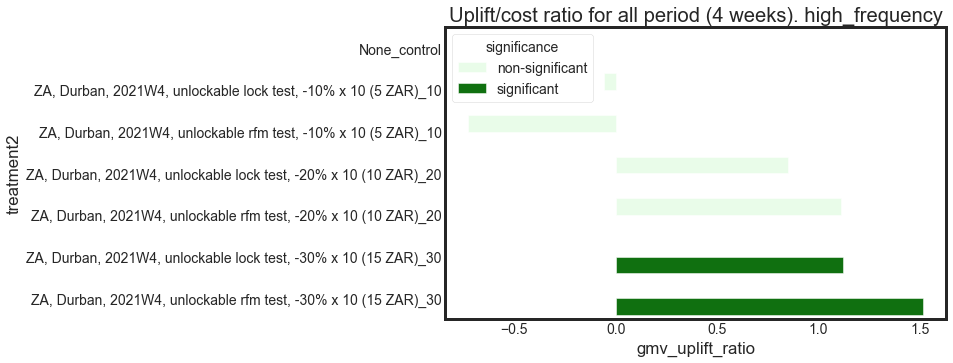

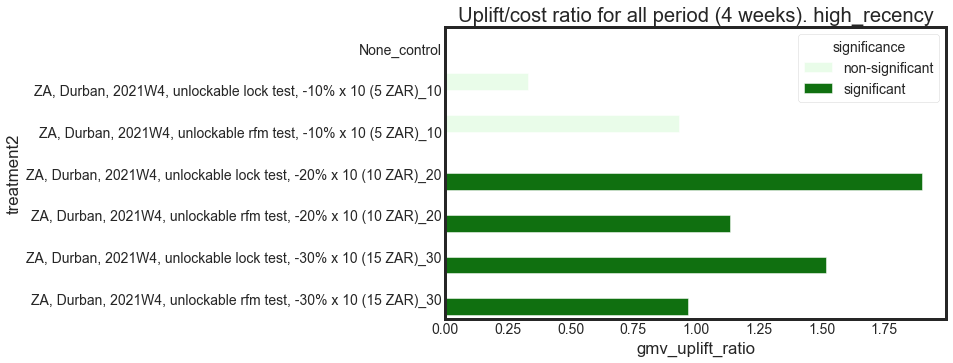

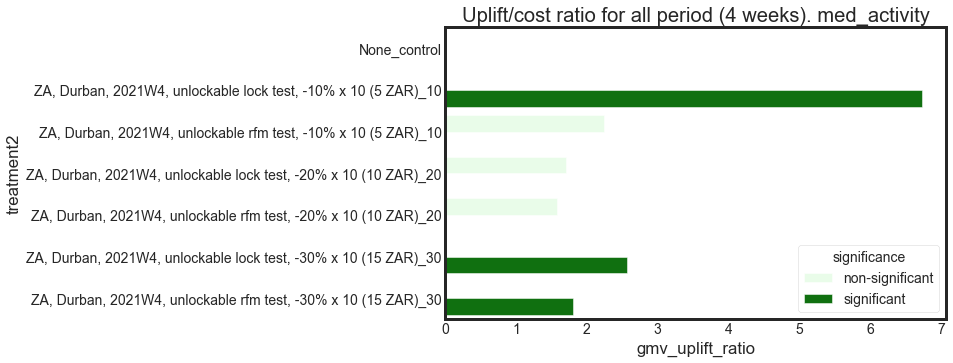

In [141]:
import seaborn as sns
dfs['significance'] = np.where(dfs['gmv_sum p-val'] <= 0.05, "significant", 'non-significant' )
for cohort in dfs.cohort.unique():
    plt.figure(figsize=(8,5))
    sns.set_style("white")
    temp = dfs[dfs['cohort'] == cohort]
    sns.barplot(y = 'treatment2', x = 'gmv_uplift_ratio', hue = 'significance', color = 'green', data = temp, orient = "h", order = order_list)
    plt.title('Uplift/cost ratio for all period (4 weeks). '  + cohort)
    plt.show
    

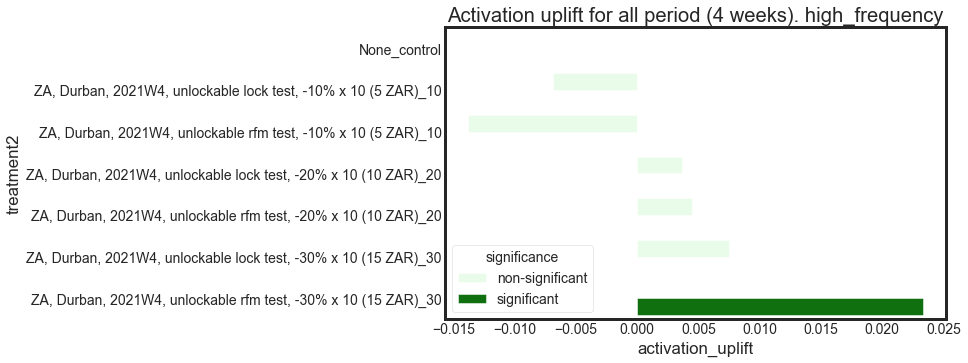

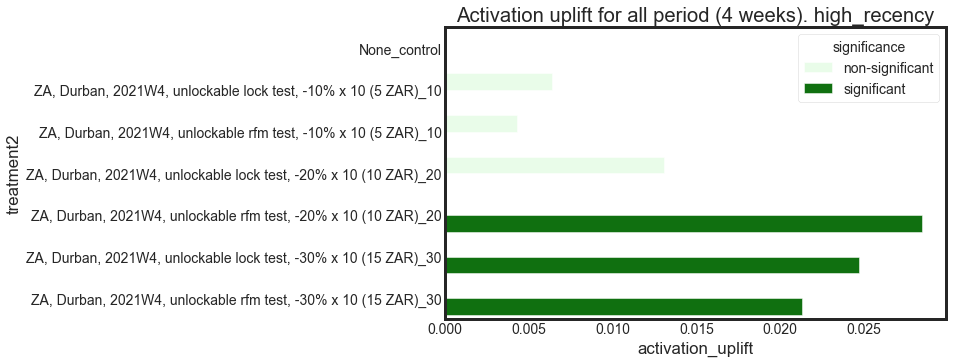

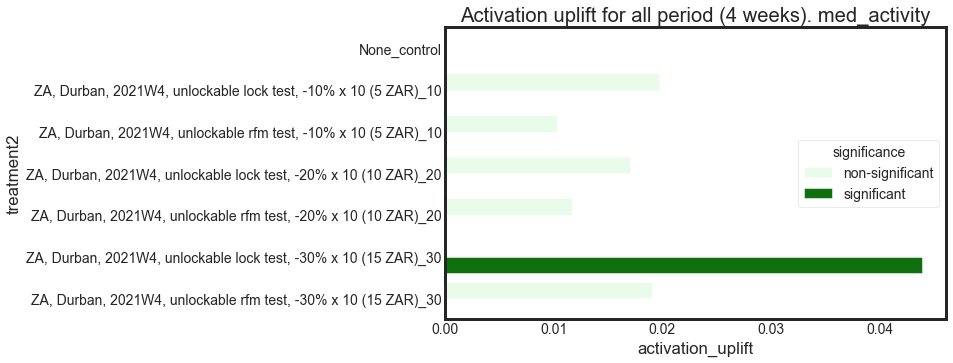

In [142]:
#activation ratio

dfs['significance'] = np.where(dfs['has_ride p-val'] <= 0.05, "significant", 'non-significant' )
for cohort in dfs.cohort.unique():
    plt.figure(figsize=(8,5))
    sns.set_style("white")
    temp = dfs[dfs['cohort'] == cohort]
    sns.barplot(y = 'treatment2', x = 'activation_uplift', hue = 'significance', color = 'green', data = temp, orient = "h", order = order_list)
    plt.title('Activation uplift for all period (4 weeks). '  + cohort)
    plt.show

# second week only

In [110]:
w = "2021-01-25" #input the week of the first campaign
activity_start = '2021-02-04'
activity_end = '2021-02-10'
overwrite_file = True

if country in ['za','ee','lv','lt']:
    #campaigns starting on Thu
    campaign_start = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=3)).strftime('%Y-%m-%d')
    campaign_end = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=3+6)).strftime( '%Y-%m-%d')
else:
    #campaigns starting on Tue
    ca_mpaign_start = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    campaign_end = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=1+6)).strftime( '%Y-%m-%d')  

filename_df_riders = 'test_activity_{}_{}_{}_{}.csv'.format(country, city,campaign_start,campaign_end, activity_start, activity_end)

if filename_df_riders not in os.listdir(data_path) or overwrite_file: 
    dfa = utils.read_from_redshift(sql_mod.format(
        campaign_start,
        campaign_end,
        city,
        activity_start,
        activity_end
    )) 
    dfa.to_csv('{}/{}'.format(data_path,filename_df_riders), compression='gzip', index=False)
else:
    print('reading from file')
    dfa = pd.read_csv('{}/{}'.format(data_path,filename_df_riders), compression = 'gzip')

query started at: 10:55:21.877715
query ended at: 10:57:44.654178


In [111]:
dft = dfa.merge(dfc, how = 'left', on = 'user_id')

dft["campaign_percentage"] = dft["campaign_percentage"].astype(str)
dft["treatment"] = np.where((dft["is_control"]==1),'control',dft["campaign_percentage"])

dft["treatment"] = np.where((dft["treatment"]=='nan'),'no_treatment',dft["treatment"])

In [112]:
#add campaign name to treatment! 
dft['treatment2'] = dft['campaign_name'].astype(str) + '_' + dft['treatment'].astype(str)
dft['treatment2'].unique()

array(['None_control',
       'ZA, Durban, 2021W4, unlockable rfm test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable lock test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable lock test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable rfm test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable rfm test, -20% x 10 (10 ZAR)_20',
       'ZA, Durban, 2021W4, unlockable lock test, -20% x 10 (10 ZAR)_20'],
      dtype=object)

In [113]:
dfa.groupby('is_in_holdout').user_id.count()

is_in_holdout
0    150737
1     81592
Name: user_id, dtype: int64

In [114]:
dft = dft[dft.is_in_holdout == 1]

In [115]:
dft

,user_id,test_id,test_name,campaign_name,treatment_type,is_control,targeted_campaign_id,campaign_percentage,campaign_max_value,is_in_holdout,finished_order_count,ride_price_sum,price_sum,discount_sum,discount_all_sum,has_ride,hp_finished_order_count,hp_ride_price_sum,hp_price_sum,hp_discount_sum,hp_discount_all_sum,hp_has_ride,method,period,city,country,cohort,treatment,treatment2
5,584162,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable rfm test, -10% ...",treatment,0,22907.000,10,5,1,1,2.237,1.790,0.000,0.447,1,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,10,"ZA, Durban, 2021W4, unlockable rfm test, -10% ..."
6,589037,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
9,597949,16047,"ZA, Durban, 2021W4, unlockable lock test, HF","ZA, Durban, 2021W4, unlockable rfm test, -10% ...",treatment,0,22907.000,10,5,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_frequency,10,"ZA, Durban, 2021W4, unlockable rfm test, -10% ..."
13,624623,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
14,628941,16047,"ZA, Durban, 2021W4, unlockable lock test, HF",None,control,1,nan,None,None,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_frequency,control,None_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232318,62559349,16046,"ZA, Durban, 2021W4, unlockable lock test, HR",None,control,1,nan,None,None,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,control,None_control
232321,62559683,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -20%...",treatment,0,22905.000,20,10,1,2,8.314,8.314,0.000,0.000,1,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,20,"ZA, Durban, 2021W4, unlockable lock test, -20%..."
232325,62561205,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable lock test, -30%...",treatment,0,22906.000,30,15,1,0,0.000,0.000,0.000,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable lock test, -30%..."
232326,62561256,16046,"ZA, Durban, 2021W4, unlockable lock test, HR","ZA, Durban, 2021W4, unlockable rfm test, -30% ...",treatment,0,22909.000,30,15,1,2,6.642,6.642,0.000,0.000,1,0.000,0.000,0.000,0.000,0.000,0.000,rfmv2,2021-01-27,Durban,za,high_recency,30,"ZA, Durban, 2021W4, unlockable rfm test, -30% ..."


In [116]:
#aggregate, calc efficiency, add p-values

fields = ['cohort', 'treatment2']
control_name = 'None_control' #name of the control group in groupby_1 array

#set names for aggregations and calcs
groupby_treatment = dft[fields[1]].unique()#this feature includes control group, "treatment"
groupby_2 = dft[fields[0]].unique() #additional groupby field, cohort, country etc
                
                
dfs = pd.DataFrame({
    "user_count":dft.groupby(fields)["user_id"].count(),
    "has_ride_sum":dft.groupby(fields)["has_ride"].sum(),
    "has_ride_avg":dft.groupby(fields)["has_ride"].mean(), 
    
    "discount_all_avg":dft.groupby(fields)["discount_all_sum"].mean(),
    #"discount_sum":dft.groupby(fields)["discount_sum"].sum(),
    "discount_avg":dft.groupby(fields)["discount_sum"].mean(),

    #"gmv_sum":dft.groupby(fields)["ride_price_sum"].sum(),
    "gmv_avg":dft.groupby(fields)["ride_price_sum"].mean(),
    
    #"nmv_sum":dft.groupby(fields)["price_sum"].sum(),
    "nmv_avg":dft.groupby(fields)["price_sum"].mean(), 
    
    #"finished_order_sum":dft.groupby(fields)["finished_order_count"].sum(),
    "finished_order_avg":dft.groupby(fields)["finished_order_count"].mean()

}).reset_index()

#add control metrics to df
dfs_control = dfs[dfs[fields[1]]==control_name][[fields[0],"gmv_avg","has_ride_avg","discount_all_avg"]]
dfs_control = dfs_control.rename(columns = {"gmv_avg":"control_gmv_avg",
                                            "has_ride_avg":"control_has_ride_avg",
                                            "discount_all_avg":"control_discount_all_avg"
                                           })
dfs = dfs.merge(dfs_control, how = 'left', on = [fields[0]])

#calculate efficiency
dfs["gmv_uplift"]= np.where(dfs[fields[1]]==control_name,
                        np.nan,
                        dfs["gmv_avg"]-dfs["control_gmv_avg"])

dfs["gmv_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["gmv_uplift"]/dfs["discount_all_avg"])

dfs["activation_uplift"] = np.where(dfs[fields[1]]==control_name,
                        np.nan,
                        dfs["has_ride_avg"]-dfs["control_has_ride_avg"])

dfs["activation_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["activation_uplift"]/dfs["discount_all_avg"])

#merge testgroup names
#dfs = pd.merge(dfs, testgroups, how = "left", left_on = "treatment", right_on= "treatment_name")

#p-value for AB
#fields in user level dataset
fields_p = ["discount_all_sum","ride_price_sum","price_sum","finished_order_count","has_ride"]


for group in groupby_2:
    for treatment in groupby_treatment: 
        for field in fields_p:
            p=ttest_2(dft[(dft[fields[1]]==control_name)&(dft[fields[0]] == group)][field],
                      dft[(dft[fields[1]]==treatment)&(dft[fields[0]] == group)][field])[1]
            p = round(p,4)
            #rename some fields
            if field == "ride_price_sum": field = "gmv_sum"
            if field == "price_sum": field = "nmv_sum"
            #print(country + ' ' + treatment + ' ' + field + ' {}'.format(p))
            dfs.loc[(dfs[fields[1]]==treatment)&(dfs[fields[0]]==group), str(field) + ' p-val'] = p
        


In [117]:
dfs.treatment2.unique()

array(['None_control',
       'ZA, Durban, 2021W4, unlockable lock test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable lock test, -20% x 10 (10 ZAR)_20',
       'ZA, Durban, 2021W4, unlockable lock test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable rfm test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable rfm test, -20% x 10 (10 ZAR)_20',
       'ZA, Durban, 2021W4, unlockable rfm test, -30% x 10 (15 ZAR)_30'],
      dtype=object)

In [118]:
dfs.to_csv('unlockable_2nd_week.csv')

In [119]:
dfs = pd.read_csv('unlockable_2nd_week.csv')

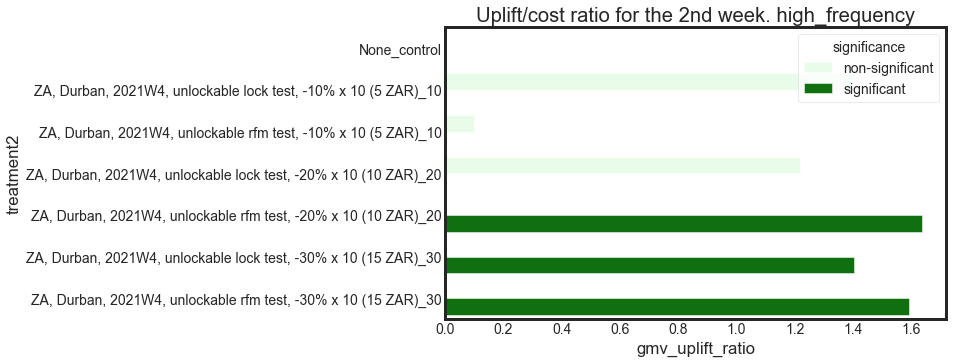

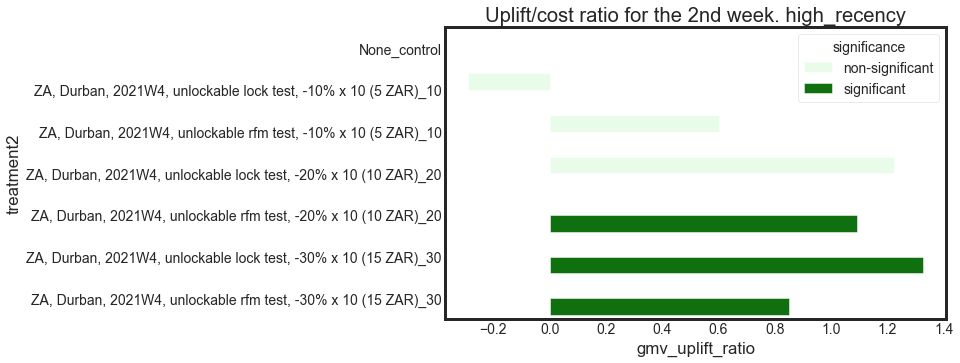

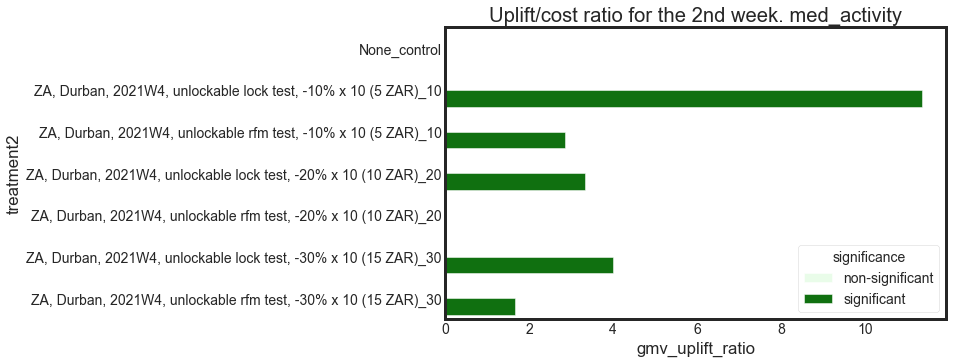

In [120]:
dfs['significance'] = np.where(dfs['gmv_sum p-val'] <= 0.05, "significant", 'non-significant' )
for cohort in dfs.cohort.unique():
    plt.figure(figsize=(8,5))
    sns.set_style("white")
    temp = dfs[dfs['cohort'] == cohort]
    sns.barplot(y = 'treatment2', x = 'gmv_uplift_ratio', hue = 'significance', color = 'green', data = temp, orient = "h", order = order_list)
    plt.title('Uplift/cost ratio for the 2nd week. ' + cohort)
    plt.show

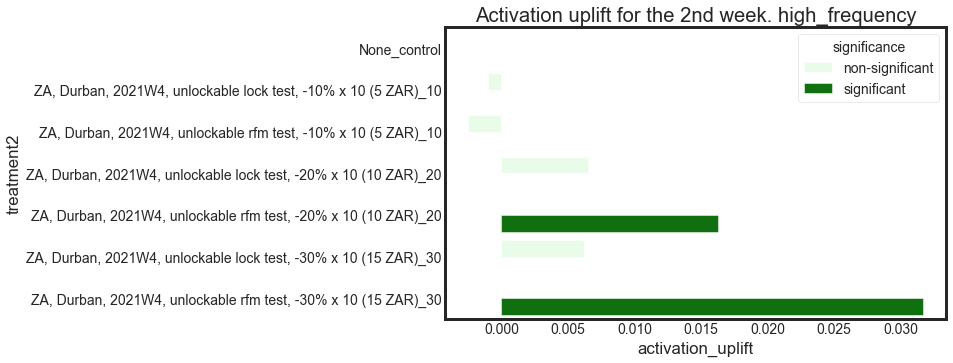

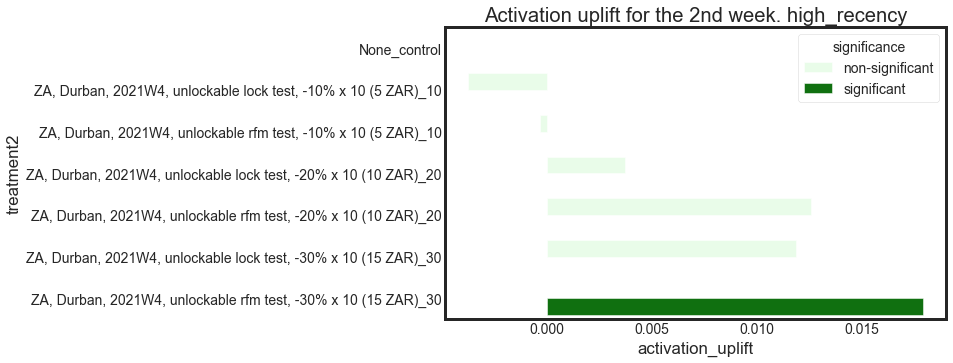

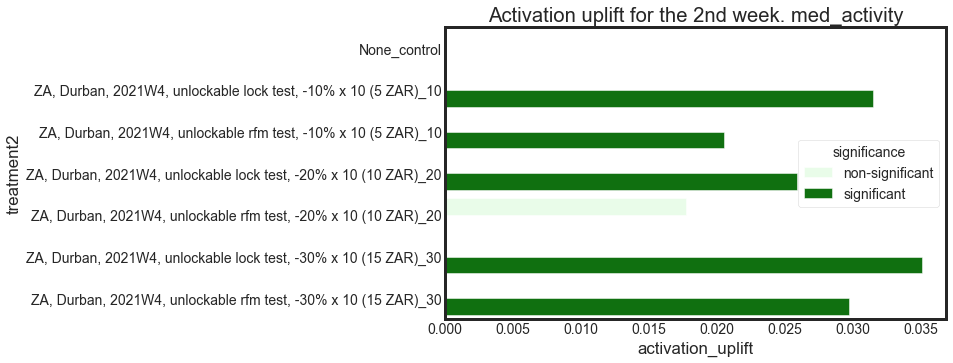

In [121]:
#activation ratio

dfs['significance'] = np.where(dfs['has_ride p-val'] <= 0.05, "significant", 'non-significant' )
for cohort in dfs.cohort.unique():
    plt.figure(figsize=(8,5))
    sns.set_style("white")
    temp = dfs[dfs['cohort'] == cohort]
    sns.barplot(y = 'treatment2', x = 'activation_uplift', hue = 'significance', color = 'green', data = temp, orient = "h", order = order_list)
    plt.title('Activation uplift for the 2nd week. ' + cohort)
    plt.show

# 2 weeks of activity

In [59]:
w = "2021-01-25" #input the week of the first campaign
activity_start = '2021-01-28'
activity_end = '2021-02-10'
overwrite_file = True

if country in ['za','ee','lv','lt']:
    #campaigns starting on Thu
    campaign_start = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=3)).strftime('%Y-%m-%d')
    campaign_end = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=3+6)).strftime( '%Y-%m-%d')
else:
    #campaigns starting on Tue
    campaign_start = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    campaign_end = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=1+6)).strftime( '%Y-%m-%d')  

filename_df_riders = 'test_activity_{}_{}_{}_{}.csv'.format(country, city,campaign_start,campaign_end, activity_start, activity_end)

if filename_df_riders not in os.listdir(data_path) or overwrite_file: 
    dfa = utils.read_from_redshift(sql_mod.format(
        campaign_start,
        campaign_end,
        city,
        activity_start,
        activity_end
    )) 
    dfa.to_csv('{}/{}'.format(data_path,filename_df_riders), compression='gzip', index=False)
else:
    print('reading from file')
    dfa = pd.read_csv('{}/{}'.format(data_path,filename_df_riders), compression = 'gzip')

query started at: 10:26:50.596582
query ended at: 10:28:42.728297


In [60]:
dft = dfa.merge(dfc, how = 'left', on = 'user_id')

dft["campaign_percentage"] = dft["campaign_percentage"].astype(str)
dft["treatment"] = np.where((dft["is_control"]==1),'control',dft["campaign_percentage"])

dft["treatment"] = np.where((dft["treatment"]=='nan'),'no_treatment',dft["treatment"])

In [61]:
#add campaign name to treatment! 
dft['treatment2'] = dft['campaign_name'].astype(str) + '_' + dft['treatment'].astype(str)
dft['treatment2'].unique()

array(['None_control',
       'ZA, Durban, 2021W4, unlockable rfm test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable lock test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable lock test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable rfm test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable rfm test, -20% x 10 (10 ZAR)_20',
       'ZA, Durban, 2021W4, unlockable lock test, -20% x 10 (10 ZAR)_20'],
      dtype=object)

In [62]:
dfa.groupby('is_in_holdout').user_id.count()

is_in_holdout
0    150737
1     81592
Name: user_id, dtype: int64

In [63]:
dft = dft[dft.is_in_holdout == 1]

In [64]:
dft[dft['hp_has_ride'] > 0]

,user_id,test_id,test_name,campaign_name,treatment_type,is_control,targeted_campaign_id,campaign_percentage,campaign_max_value,is_in_holdout,finished_order_count,ride_price_sum,price_sum,discount_sum,discount_all_sum,has_ride,hp_finished_order_count,hp_ride_price_sum,hp_price_sum,hp_discount_sum,hp_discount_all_sum,hp_has_ride,method,period,city,country,cohort,treatment,treatment2


In [65]:
#aggregate, calc efficiency, add p-values

fields = ['cohort', 'treatment2']
control_name = 'None_control' #name of the control group in groupby_1 array

#set names for aggregations and calcs
groupby_treatment = dft[fields[1]].unique()#this feature includes control group, "treatment"
groupby_2 = dft[fields[0]].unique() #additional groupby field, cohort, country etc
                
                
dfs = pd.DataFrame({
    "user_count":dft.groupby(fields)["user_id"].count(),
    "has_ride_sum":dft.groupby(fields)["has_ride"].sum(),
    "has_ride_avg":dft.groupby(fields)["has_ride"].mean(), 
    
    "discount_all_avg":dft.groupby(fields)["discount_all_sum"].mean(),
    #"discount_sum":dft.groupby(fields)["discount_sum"].sum(),
    "discount_avg":dft.groupby(fields)["discount_sum"].mean(),

    #"gmv_sum":dft.groupby(fields)["ride_price_sum"].sum(),
    "gmv_avg":dft.groupby(fields)["ride_price_sum"].mean(),
    
    #"nmv_sum":dft.groupby(fields)["price_sum"].sum(),
    "nmv_avg":dft.groupby(fields)["price_sum"].mean(), 
    
    #"finished_order_sum":dft.groupby(fields)["finished_order_count"].sum(),
    "finished_order_avg":dft.groupby(fields)["finished_order_count"].mean()

}).reset_index()

#add control metrics to df
dfs_control = dfs[dfs[fields[1]]==control_name][[fields[0],"gmv_avg","has_ride_avg","discount_all_avg"]]
dfs_control = dfs_control.rename(columns = {"gmv_avg":"control_gmv_avg",
                                            "has_ride_avg":"control_has_ride_avg",
                                            "discount_all_avg":"control_discount_all_avg"
                                           })
dfs = dfs.merge(dfs_control, how = 'left', on = [fields[0]])

#calculate efficiency
dfs["gmv_uplift"]= np.where(dfs[fields[1]]==control_name,
                        np.nan,
                        dfs["gmv_avg"]-dfs["control_gmv_avg"])

dfs["gmv_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["gmv_uplift"]/dfs["discount_all_avg"])

dfs["activation_uplift"] = np.where(dfs[fields[1]]==control_name,
                        np.nan,
                        dfs["has_ride_avg"]-dfs["control_has_ride_avg"])

dfs["activation_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["activation_uplift"]/dfs["discount_all_avg"])

#merge testgroup names
#dfs = pd.merge(dfs, testgroups, how = "left", left_on = "treatment", right_on= "treatment_name")

#p-value for AB
#fields in user level dataset
fields_p = ["discount_all_sum","ride_price_sum","price_sum","finished_order_count","has_ride"]


for group in groupby_2:
    for treatment in groupby_treatment: 
        for field in fields_p:
            p=ttest_2(dft[(dft[fields[1]]==control_name)&(dft[fields[0]] == group)][field],
                      dft[(dft[fields[1]]==treatment)&(dft[fields[0]] == group)][field])[1]
            p = round(p,4)
            #rename some fields
            if field == "ride_price_sum": field = "gmv_sum"
            if field == "price_sum": field = "nmv_sum"
            #print(country + ' ' + treatment + ' ' + field + ' {}'.format(p))
            dfs.loc[(dfs[fields[1]]==treatment)&(dfs[fields[0]]==group), str(field) + ' p-val'] = p
        


In [66]:
dfs

,cohort,treatment2,user_count,has_ride_sum,has_ride_avg,discount_all_avg,discount_avg,gmv_avg,nmv_avg,finished_order_avg,control_gmv_avg,control_has_ride_avg,control_discount_all_avg,gmv_uplift,gmv_uplift_ratio,activation_uplift,activation_uplift_ratio,discount_all_sum p-val,gmv_sum p-val,nmv_sum p-val,finished_order_count p-val,has_ride p-val
0,high_frequency,None_control,4712,1082,0.230,0.002,0.000,1.319,1.317,0.534,1.319,0.230,0.002,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
1,high_frequency,"ZA, Durban, 2021W4, unlockable lock test, -10%...",4655,1077,0.231,0.084,0.049,1.375,1.291,0.540,1.319,0.230,0.002,0.056,0.671,0.002,0.021,0.000,0.479,0.737,0.831,0.842
2,high_frequency,"ZA, Durban, 2021W4, unlockable lock test, -20%...",4741,1153,0.243,0.201,0.125,1.574,1.373,0.636,1.319,0.230,0.002,0.255,1.268,0.014,0.067,0.000,0.004,0.493,0.002,0.120
3,high_frequency,"ZA, Durban, 2021W4, unlockable lock test, -30%...",4723,1164,0.246,0.320,0.203,1.712,1.392,0.682,1.319,0.230,0.002,0.393,1.229,0.017,0.053,0.000,0.000,0.346,0.000,0.055
4,high_frequency,"ZA, Durban, 2021W4, unlockable rfm test, -10% ...",4607,1072,0.233,0.113,0.050,1.339,1.226,0.535,1.319,0.230,0.002,0.020,0.174,0.003,0.027,0.000,0.808,0.238,0.976,0.726
5,high_frequency,"ZA, Durban, 2021W4, unlockable rfm test, -20% ...",4676,1149,0.246,0.226,0.112,1.580,1.354,0.612,1.319,0.230,0.002,0.261,1.153,0.016,0.071,0.000,0.003,0.660,0.012,0.067
6,high_frequency,"ZA, Durban, 2021W4, unlockable rfm test, -30% ...",4670,1244,0.266,0.358,0.197,1.751,1.393,0.710,1.319,0.230,0.002,0.432,1.206,0.037,0.103,0.000,0.000,0.337,0.000,0.000
7,high_recency,None_control,4779,1168,0.244,0.003,0.000,1.353,1.350,0.511,1.353,0.244,0.003,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
8,high_recency,"ZA, Durban, 2021W4, unlockable lock test, -10%...",4772,1210,0.254,0.081,0.054,1.346,1.265,0.540,1.353,0.244,0.003,-0.007,-0.087,0.009,0.113,0.000,0.931,0.281,0.314,0.301
9,high_recency,"ZA, Durban, 2021W4, unlockable lock test, -20%...",4903,1280,0.261,0.195,0.133,1.604,1.409,0.629,1.353,0.244,0.003,0.251,1.292,0.017,0.086,0.000,0.005,0.477,0.000,0.059


In [67]:
dfs.to_csv('unlockable_2weeks_of_activity.csv')

In [122]:
dfs = pd.read_csv('unlockable_2weeks_of_activity.csv')

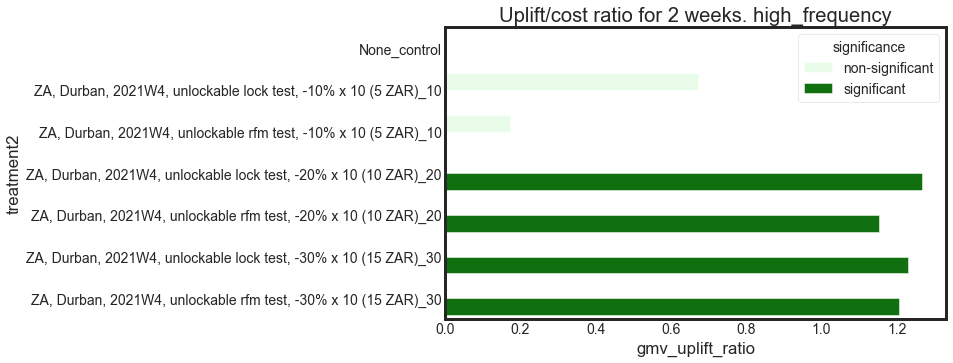

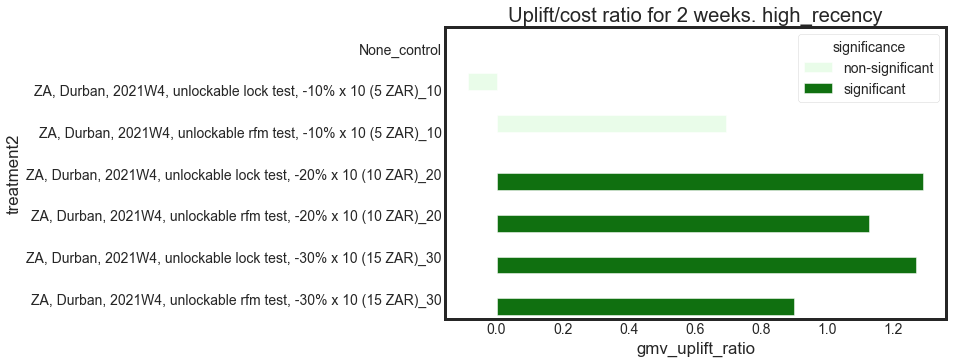

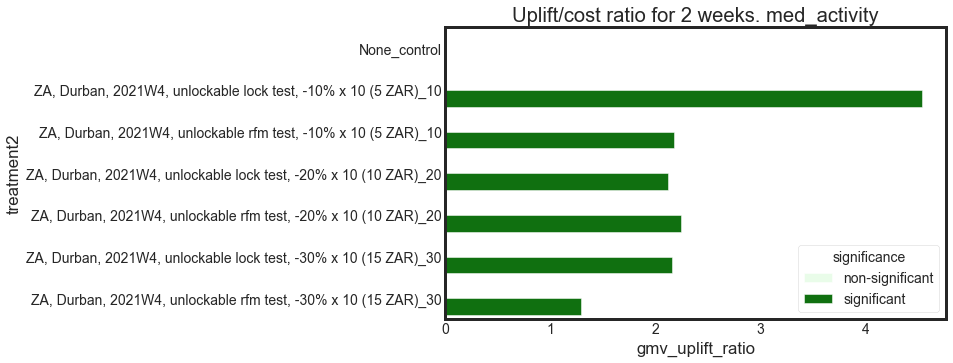

In [123]:
dfs['significance'] = np.where(dfs['gmv_sum p-val'] <= 0.05, "significant", 'non-significant' )
for cohort in dfs.cohort.unique():
    plt.figure(figsize=(8,5))
    sns.set_style("white")
    temp = dfs[dfs['cohort'] == cohort]
    sns.barplot(y = 'treatment2', x = 'gmv_uplift_ratio', hue = 'significance', color = 'green', data = temp, orient = "h", order = order_list)
    plt.title('Uplift/cost ratio for 2 weeks. ' + cohort)
    plt.show
    

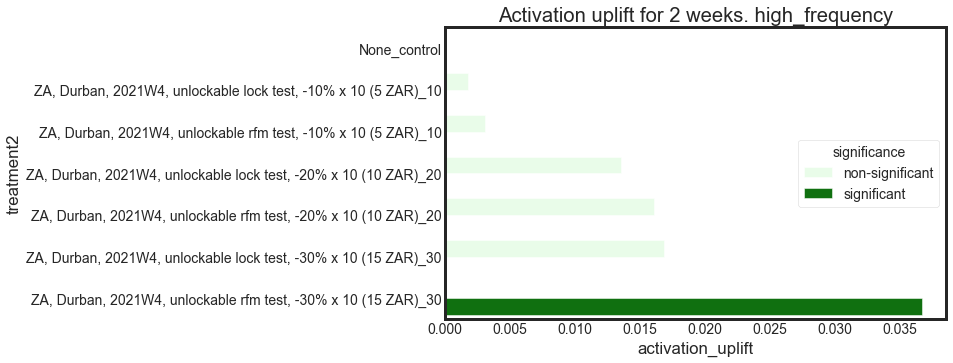

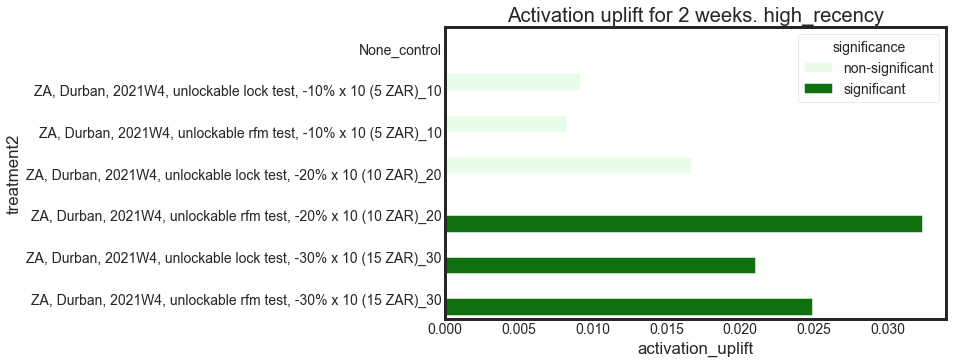

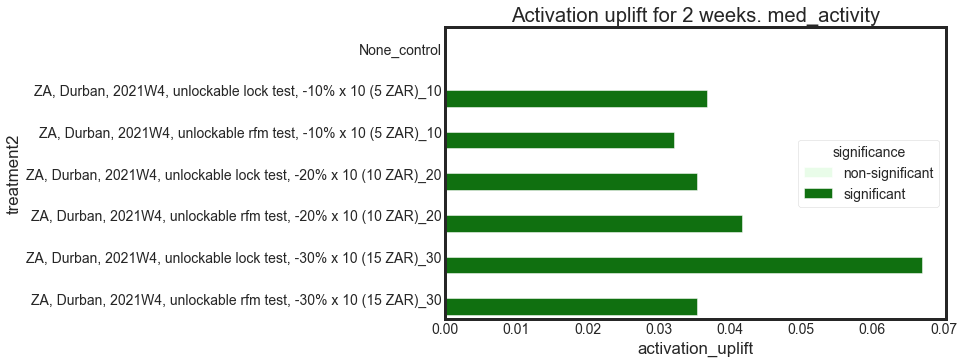

In [125]:
#activation ratio

dfs['significance'] = np.where(dfs['has_ride p-val'] <= 0.05, "significant", 'non-significant' )
for cohort in dfs.cohort.unique():
    plt.figure(figsize=(8,5))
    sns.set_style("white")
    temp = dfs[dfs['cohort'] == cohort]
    sns.barplot(y = 'treatment2', x = 'activation_uplift', hue = 'significance', color = 'green', data = temp, orient = "h", order = order_list)
    plt.title('Activation uplift for 2 weeks. ' + cohort)
    plt.show

# 1 week only

In [126]:
w = "2021-01-25" #input the week of the first campaign
activity_start = '2021-01-28'
activity_end = '2021-02-03'
overwrite_file = True

if country in ['za','ee','lv','lt']:
    #campaigns starting on Thu
    campaign_start = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=3)).strftime('%Y-%m-%d')
    campaign_end = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=3+6)).strftime( '%Y-%m-%d')
else:
    #campaigns starting on Tue
    campaign_start = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    campaign_end = (datetime.datetime.strptime(w, '%Y-%m-%d') + datetime.timedelta(days=1+6)).strftime( '%Y-%m-%d')  

filename_df_riders = 'test_activity_{}_{}_{}_{}.csv'.format(country, city,campaign_start,campaign_end, activity_start, activity_end)

if filename_df_riders not in os.listdir(data_path) or overwrite_file: 
    dfa = utils.read_from_redshift(sql_mod.format(
        campaign_start,
        campaign_end,
        city,
        activity_start,
        activity_end
    )) 
    dfa.to_csv('{}/{}'.format(data_path,filename_df_riders), compression='gzip', index=False)
else:
    print('reading from file')
    dfa = pd.read_csv('{}/{}'.format(data_path,filename_df_riders), compression = 'gzip')

query started at: 11:03:24.680576
query ended at: 11:04:31.736517


In [127]:
dft = dfa.merge(dfc, how = 'left', on = 'user_id')

dft["campaign_percentage"] = dft["campaign_percentage"].astype(str)
dft["treatment"] = np.where((dft["is_control"]==1),'control',dft["campaign_percentage"])

dft["treatment"] = np.where((dft["treatment"]=='nan'),'no_treatment',dft["treatment"])

In [128]:
#add campaign name to treatment! 
dft['treatment2'] = dft['campaign_name'].astype(str) + '_' + dft['treatment'].astype(str)
dft['treatment2'].unique()

array(['None_control',
       'ZA, Durban, 2021W4, unlockable rfm test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable lock test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable lock test, -10% x 10 (5 ZAR)_10',
       'ZA, Durban, 2021W4, unlockable rfm test, -30% x 10 (15 ZAR)_30',
       'ZA, Durban, 2021W4, unlockable rfm test, -20% x 10 (10 ZAR)_20',
       'ZA, Durban, 2021W4, unlockable lock test, -20% x 10 (10 ZAR)_20'],
      dtype=object)

In [129]:
dfa.groupby('is_in_holdout').user_id.count()

is_in_holdout
0    150737
1     81592
Name: user_id, dtype: int64

In [130]:
dft = dft[dft.is_in_holdout == 1]

In [131]:
dft[dft['hp_has_ride'] > 0]

,user_id,test_id,test_name,campaign_name,treatment_type,is_control,targeted_campaign_id,campaign_percentage,campaign_max_value,is_in_holdout,finished_order_count,ride_price_sum,price_sum,discount_sum,discount_all_sum,has_ride,hp_finished_order_count,hp_ride_price_sum,hp_price_sum,hp_discount_sum,hp_discount_all_sum,hp_has_ride,method,period,city,country,cohort,treatment,treatment2


In [132]:
#aggregate, calc efficiency, add p-values

fields = ['cohort', 'treatment2']
control_name = 'None_control' #name of the control group in groupby_1 array

#set names for aggregations and calcs
groupby_treatment = dft[fields[1]].unique()#this feature includes control group, "treatment"
groupby_2 = dft[fields[0]].unique() #additional groupby field, cohort, country etc
                
                
dfs = pd.DataFrame({
    "user_count":dft.groupby(fields)["user_id"].count(),
    "has_ride_sum":dft.groupby(fields)["has_ride"].sum(),
    "has_ride_avg":dft.groupby(fields)["has_ride"].mean(), 
    
    "discount_all_avg":dft.groupby(fields)["discount_all_sum"].mean(),
    #"discount_sum":dft.groupby(fields)["discount_sum"].sum(),
    "discount_avg":dft.groupby(fields)["discount_sum"].mean(),

    #"gmv_sum":dft.groupby(fields)["ride_price_sum"].sum(),
    "gmv_avg":dft.groupby(fields)["ride_price_sum"].mean(),
    
    #"nmv_sum":dft.groupby(fields)["price_sum"].sum(),
    "nmv_avg":dft.groupby(fields)["price_sum"].mean(), 
    
    #"finished_order_sum":dft.groupby(fields)["finished_order_count"].sum(),
    "finished_order_avg":dft.groupby(fields)["finished_order_count"].mean()

}).reset_index()

#add control metrics to df
dfs_control = dfs[dfs[fields[1]]==control_name][[fields[0],"gmv_avg","has_ride_avg","discount_all_avg"]]
dfs_control = dfs_control.rename(columns = {"gmv_avg":"control_gmv_avg",
                                            "has_ride_avg":"control_has_ride_avg",
                                            "discount_all_avg":"control_discount_all_avg"
                                           })
dfs = dfs.merge(dfs_control, how = 'left', on = [fields[0]])

#calculate efficiency
dfs["gmv_uplift"]= np.where(dfs[fields[1]]==control_name,
                        np.nan,
                        dfs["gmv_avg"]-dfs["control_gmv_avg"])

dfs["gmv_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["gmv_uplift"]/dfs["discount_all_avg"])

dfs["activation_uplift"] = np.where(dfs[fields[1]]==control_name,
                        np.nan,
                        dfs["has_ride_avg"]-dfs["control_has_ride_avg"])

dfs["activation_uplift_ratio"]=np.where(dfs[fields[1]]==control_name,
                            np.nan,
                            dfs["activation_uplift"]/dfs["discount_all_avg"])

#merge testgroup names
#dfs = pd.merge(dfs, testgroups, how = "left", left_on = "treatment", right_on= "treatment_name")

#p-value for AB
#fields in user level dataset
fields_p = ["discount_all_sum","ride_price_sum","price_sum","finished_order_count","has_ride"]


for group in groupby_2:
    for treatment in groupby_treatment: 
        for field in fields_p:
            p=ttest_2(dft[(dft[fields[1]]==control_name)&(dft[fields[0]] == group)][field],
                      dft[(dft[fields[1]]==treatment)&(dft[fields[0]] == group)][field])[1]
            p = round(p,4)
            #rename some fields
            if field == "ride_price_sum": field = "gmv_sum"
            if field == "price_sum": field = "nmv_sum"
            #print(country + ' ' + treatment + ' ' + field + ' {}'.format(p))
            dfs.loc[(dfs[fields[1]]==treatment)&(dfs[fields[0]]==group), str(field) + ' p-val'] = p
        


In [133]:
dfs

,cohort,treatment2,user_count,has_ride_sum,has_ride_avg,discount_all_avg,discount_avg,gmv_avg,nmv_avg,finished_order_avg,control_gmv_avg,control_has_ride_avg,control_discount_all_avg,gmv_uplift,gmv_uplift_ratio,activation_uplift,activation_uplift_ratio,discount_all_sum p-val,gmv_sum p-val,nmv_sum p-val,finished_order_count p-val,has_ride p-val
0,high_frequency,None_control,4712,686,0.146,0.001,0.000,0.654,0.653,0.256,0.654,0.146,0.001,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
1,high_frequency,"ZA, Durban, 2021W4, unlockable lock test, -10%...",4655,687,0.148,0.050,0.049,0.662,0.613,0.261,0.654,0.146,0.001,0.008,0.169,0.002,0.040,0.000,0.855,0.363,0.774,0.785
2,high_frequency,"ZA, Durban, 2021W4, unlockable lock test, -20%...",4741,778,0.164,0.126,0.125,0.817,0.691,0.326,0.654,0.146,0.001,0.163,1.299,0.019,0.147,0.000,0.001,0.417,0.000,0.013
3,high_frequency,"ZA, Durban, 2021W4, unlockable lock test, -30%...",4723,804,0.170,0.204,0.203,0.885,0.681,0.350,0.654,0.146,0.001,0.231,1.132,0.025,0.121,0.000,0.000,0.552,0.000,0.001
4,high_frequency,"ZA, Durban, 2021W4, unlockable rfm test, -10% ...",4607,691,0.150,0.051,0.050,0.667,0.616,0.260,0.654,0.146,0.001,0.014,0.263,0.004,0.086,0.000,0.782,0.430,0.824,0.549
5,high_frequency,"ZA, Durban, 2021W4, unlockable rfm test, -20% ...",4676,723,0.155,0.112,0.112,0.727,0.616,0.288,0.654,0.146,0.001,0.073,0.657,0.009,0.081,0.000,0.129,0.406,0.062,0.221
6,high_frequency,"ZA, Durban, 2021W4, unlockable rfm test, -30% ...",4670,795,0.170,0.197,0.197,0.829,0.632,0.341,0.654,0.146,0.001,0.175,0.889,0.025,0.125,0.000,0.001,0.635,0.000,0.001
7,high_recency,None_control,4779,751,0.157,0.001,0.000,0.706,0.705,0.269,0.706,0.157,0.001,nan,nan,nan,nan,1.000,1.000,1.000,1.000,1.000
8,high_recency,"ZA, Durban, 2021W4, unlockable lock test, -10%...",4772,811,0.170,0.054,0.054,0.707,0.653,0.287,0.706,0.157,0.001,0.001,0.016,0.013,0.239,0.000,0.986,0.285,0.278,0.091
9,high_recency,"ZA, Durban, 2021W4, unlockable lock test, -20%...",4903,905,0.185,0.133,0.133,0.882,0.749,0.352,0.706,0.157,0.001,0.176,1.323,0.027,0.206,0.000,0.001,0.389,0.000,0.000


In [134]:
dfs.to_csv('unlockable_1st_week_only.csv')

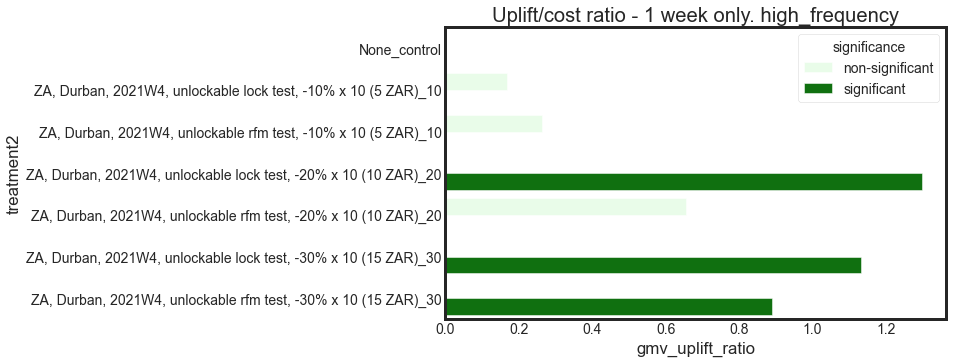

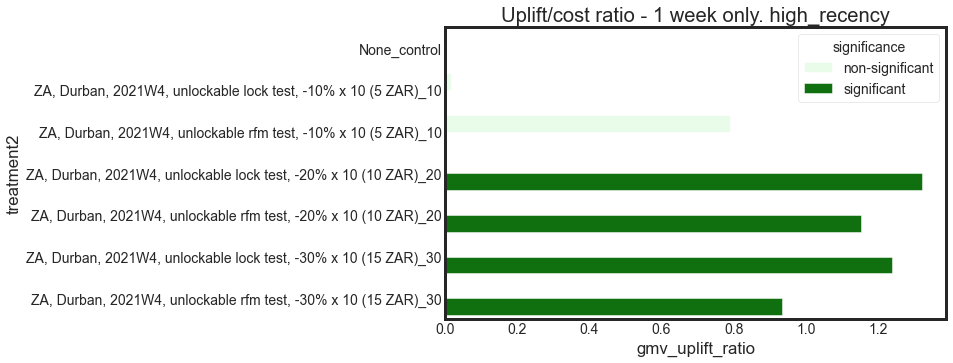

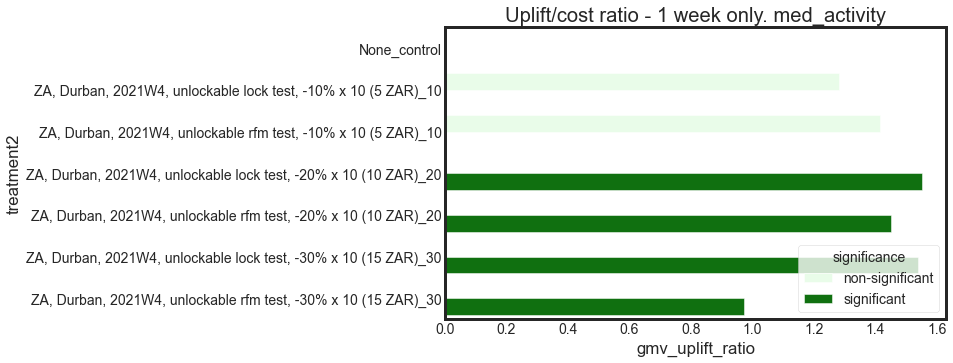

In [138]:
dfs['significance'] = np.where(dfs['gmv_sum p-val'] <= 0.05, "significant", 'non-significant' )
for cohort in dfs.cohort.unique():
    plt.figure(figsize=(8,5))
    temp = dfs[dfs['cohort'] == cohort]
    sns.barplot(y = 'treatment2', x = 'gmv_uplift_ratio', hue = 'significance', color = 'green', data = temp, orient = "h", order = order_list)
    plt.title('Uplift/cost ratio - 1 week only. ' + cohort)
    plt.show
    

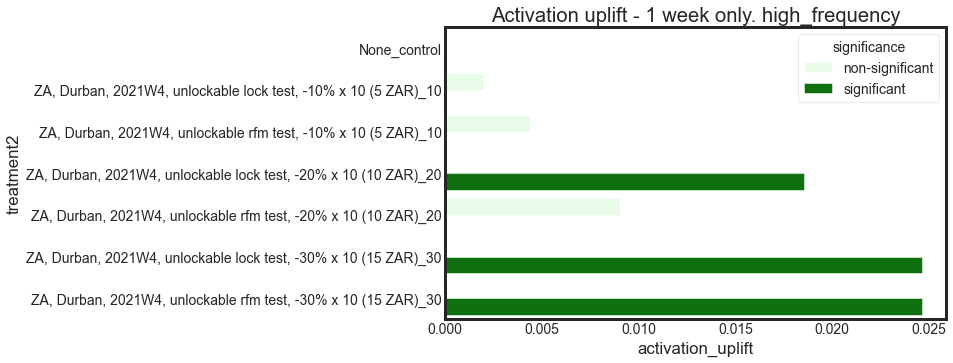

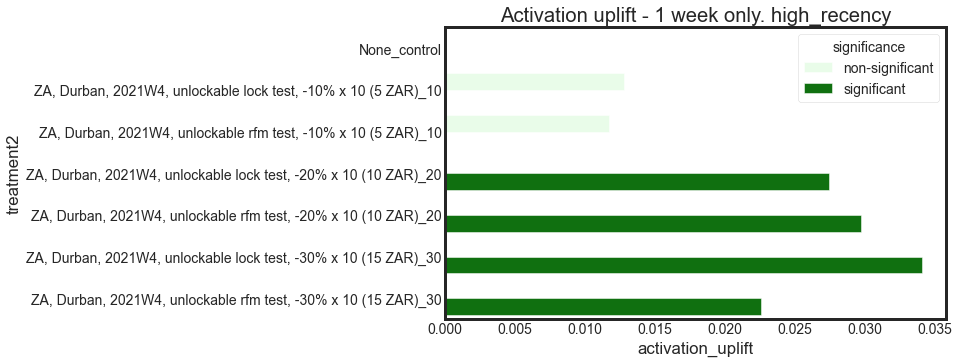

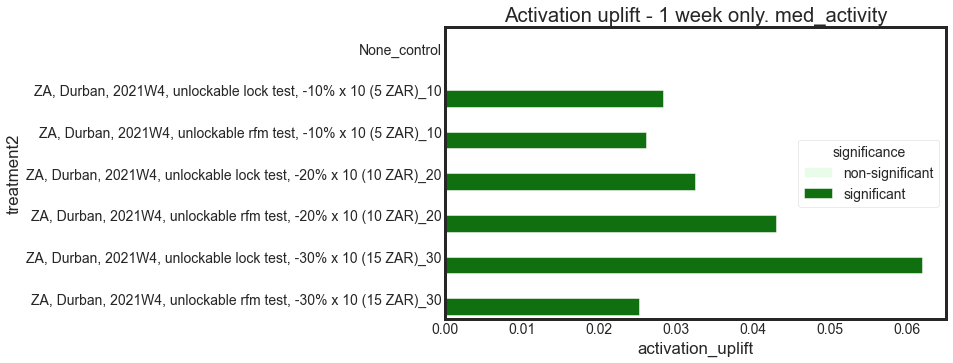

In [139]:
#activation ratio

dfs['significance'] = np.where(dfs['has_ride p-val'] <= 0.05, "significant", 'non-significant' )
for cohort in dfs.cohort.unique():
    plt.figure(figsize=(8,5))
    temp = dfs[dfs['cohort'] == cohort]
    sns.barplot(y = 'treatment2', x = 'activation_uplift', hue = 'significance', color = 'green', data = temp, orient = "h", order = order_list)
    plt.title('Activation uplift - 1 week only. ' + cohort)
    plt.show